In [1]:
#平滑
#平滑也叫做模糊，主要是需要一个滤波器过滤噪点。
#至于滤波器，一般是现行滤波器。
#g(i,j) = sum(f((i+k, j+l)))h(k,l)
#是一个加权和。其中h(h,j)是一个核(kernel)。类似窗口滑过图像。
#归一化滤波 Normalized Box Filter
#高斯滤波 Gaussian Filter
#中值滤波器 Median Filter
#双边滤波 Bilateral Filter

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
#几个基本的numpy函数
x1 = np.arange(12)
x1 = np.reshape(x1, (3,4))
print("x1", x1)
x2 = np.arange(20)
x2 = np.reshape(x2, (4,5))
print("x2", x2)
x3 = np.array([[1,1,1],[1,0,1],[1,1,1]])
x3 = x3*x3
print("x3", x3)
#如何计算kernel和原图的“乘”呢？
#利用np同维度的数组乘法。它是对应元素相乘。
for i in range(1,3):
    for j in range(1,3):
        x4 = x3 *x2[i-1:i+2, j-1:j+2]
        sum = np.sum(x4)/9
        print("x4", x4)
        print("sum", sum)
        x2[i,j] = sum
        print("filted x2", x2)
        

x1 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]
x2 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
x3 [[1 1 1]
 [1 0 1]
 [1 1 1]]
x4 [[ 0  1  2]
 [ 5  0  7]
 [10 11 12]]
sum 5.333333333333333
filted x2 [[ 0  1  2  3  4]
 [ 5  5  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
x4 [[ 1  2  3]
 [ 5  0  8]
 [11 12 13]]
sum 6.111111111111111
filted x2 [[ 0  1  2  3  4]
 [ 5  5  6  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]]
x4 [[ 5  5  6]
 [10  0 12]
 [15 16 17]]
sum 9.555555555555555
filted x2 [[ 0  1  2  3  4]
 [ 5  5  6  8  9]
 [10  9 12 13 14]
 [15 16 17 18 19]]
x4 [[ 5  6  8]
 [ 9  0 13]
 [16 17 18]]
sum 10.222222222222221
filted x2 [[ 0  1  2  3  4]
 [ 5  5  6  8  9]
 [10  9 10 13 14]
 [15 16 17 18 19]]


In [4]:
#添加噪声
def random_noise_generator(src):
    # 加上高斯噪声
    param=25
    # 灰阶范围
    grayscale=256
    w=src.shape[1]
    h=src.shape[0]
    newsrc=np.zeros((h,w),np.uint8)
    
    for x in range(0,h):
        for y in range(0,w,2):
            r1 = np.random.random_sample()
            r2 = np.random.random_sample()
            z1=param*np.cos(2*np.pi*r2)*np.sqrt((-2)*np.log(r1))
            z2=param*np.sin(2*np.pi*r2)*np.sqrt((-2)*np.log(r1))
    
            fxy=int(src[x,y]+z1)
            fxy1 = int(src[x,y+1]+z2)
            #f(x,y)
            if fxy<0:
                fxy_val=0
            elif fxy>grayscale-1:
                fxy_val=grayscale-1
            else:
                fxy_val=fxy
            #f(x,y+1)
            if fxy1<0:
                fxy1_val=0
            elif fxy1>grayscale-1:
                fxy1_val=grayscale-1
            else:
                fxy1_val=fxy1
            newsrc[x,y]=fxy_val
            newsrc[x,y+1]=fxy1_val
        #print("-")
    return newsrc

In [5]:
def normalized_box_filter(src,k_w=5, k_h=5):
    h = src.shape[0]
    w = src.shape[1]
    dest = np.zeros((h,w),np.uint8)
    kernel = np.ones((k_h,k_w),np.uint8)
    dest = src.copy()
    sum = 0
    #print("src.shape", src.shape)
    k1 = int(k_w/2) #转成int型
    k2 = int(k_h/2)
    for i in range(k1,h-k1-1):
        for j in range(k2,w-k2-1):
            temp = kernel*src[(i-k1):(i+k1+1), (j-k2):(j+k2+1)]
            #print("i", i)
            #print("j", j)
            #print("temp", temp)
            sum = np.sum(temp)/(k_w*k_h)
            dest[i,j] = sum
    return dest
    

In [6]:
def median_filter(src,k_w=5, k_h=5):
    h = src.shape[0]
    w = src.shape[1]
    dest = np.zeros((h,w),np.uint8)
    kernel = np.ones((k_h,k_w),np.uint8)
    dest = src.copy()
    sum = 0
    #print("src.shape", src.shape)
    k1 = int(k_w/2) #转成int型
    k2 = int(k_h/2)
    for i in range(k1,h-k1-1):
        for j in range(k2,w-k2-1):
            temp = np.median(src[(i-k1):(i+k1+1), (j-k2):(j+k2+1)])
            dest[i,j] = temp
    return dest

In [7]:
#如果sigma较小，那么生成的模板的中心系数较大，而周围的系数较小，这样对图像的平滑效果就不是很明显；
#反之,sigma较大，则生成的模板的各个系数相差就不是很大，比较类似均值模板，对图像的平滑效果比较明显
#也就是:
#sigma越大，分布越分散，各部分比重差别不大，于是生成的模板各元素值差别不大，类似于平均模板；
#sigma越小，分布越集中，中间部分所占比重远远高于其他部分，反映到高斯模板上就是中心元素值远远大于其他元素值，于是自然而然就相当于中间值得点运算。
#https://www.cnblogs.com/wangguchangqing/p/6407717.html#autoid-2-0-0
def Gaussian_filter(src, sigma=1.0, k_w = 3, k_h = 3):
    #产生高斯核
    h = src.shape[0]
    w = src.shape[1]
    dest = np.zeros((h,w), np.uint8)
    kernel = np.zeros((k_h,k_w), np.float)
    dest = src.copy()
    
    for i in range(k_h):
        for j in range(k_w):
            n = -(np.power(i,2)+np.power(j,2))/(2*np.power(sigma,2))
            #np.exp(n) n意味着e的n次方
            #print("n:", n)
            #print("(%d, %d) np.exp(%d):", i, j, n, np.exp(n))
            kernel[i,j] = np.exp(n)/(2*3.14*np.power(sigma,2))
    #归一化操作
    kernel=kernel/np.sum(kernel)
    #print("kernel,sum", kernel,np.sum(kernel))
    
    
    k1 = int(k_w/2) #转成int型
    k2 = int(k_h/2)
    for i in range(k1,h-k1-1):
        for j in range(k2,w-k2-1):
            temp = kernel*src[(i-k1):(i+k1+1), (j-k2):(j+k2+1)]
            dest[i,j] = np.sum(temp)
    return dest

In [41]:
def bilateral_filter(src, k_w=5, k_h=5, sigma_d = 0.2, sigma_r=2):
    h = src.shape[0]
    w = src.shape[1]
    #计算spatial kernel
    gaussian_d_coeff = -0.5*sigma_d*sigma_d
    gaussian_r_coeff = -0.5*sigma_r*sigma_r
    dest = np.zeros((h,w), np.uint8)
    dest = src.copy()
    #print("gaussian_d_coeff",gaussian_d_coeff)
    #print("gaussian_r_coeff",gaussian_r_coeff)
    kernel_d = np.zeros((k_w,k_h), np.float)
    metrix_r = np.zeros(256,np.float)
    for i in range(k_h):
        for j in range(k_w):
            kernel_d[i,j] = np.exp((np.power((k_w/2-i), 2)+np.power((k_h/2-j),2))*gaussian_d_coeff)
    #print("kernel_d", kernel_d)
    #计算similarity矩阵
    '''
    for i in range(256):
        metrix_r[i] = np.exp(i*i*gaussian_r_coeff)
    #print("metrix_r", metrix_r)
    '''
    
    r = int(k_w/2) #转成int型
    #k2 = int(k_h/2)
    for i in range(r,h-r-1):
        for j in range(r,w-r-1):
            #print("src[i,j]",src[i,j])
            #print("src[i+r,j]",src[i+r,j])
            
            #index = np.abs(src[i,j]-src[i+r,j])
            #if index > 255:
            #    index = 255
            dL = src[i+r+1,j+r+1] - src[i,j]
            H = np.exp(dL*dL*gaussian_r_coeff)
            weight = kernel_d*H
            #print("weight",weight)
            weight_sum = np.sum(weight)
            if weight_sum ==0:
                weight_sum = 1
            weight = weight/weight_sum
            temp = weight*src[(i-r):(i+r+1), (j-r):(j+r+1)]
            temp.dtype = 'uint8' 
            #print("temp",temp)
            if np.sum(temp) != 0:
                dest[i,j] = np.sum(temp)
            #print("i,j,dest[i,j]", i, j, dest[i,j])
    return dest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in ubyte_scalars


(-0.5, 511.5, 511.5, -0.5)

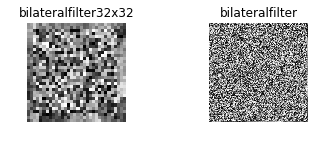

In [42]:
grayImage_noise32x32 = random_noise_generator(grayImage32x32)
gray_image_bilateralfilter32x32 = bilateral_filter(grayImage_noise32x32,k_w=5, k_h=5, sigma_d = 0.2, sigma_r=2)

grayImage_noise = random_noise_generator(grayImage)
gray_image_bilateralfilter = bilateral_filter(grayImage_noise,k_w=5, k_h=5, sigma_d = 0.2, sigma_r=2)

#print("gray_image_bilateralfilter32x32",gray_image_bilateralfilter32x32)
plt.subplot(2, 2, 1)
plt.title("bilateralfilter32x32")
plt.imshow(gray_image_bilateralfilter32x32)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("bilateralfilter")
plt.imshow(gray_image_bilateralfilter)
plt.axis('off')

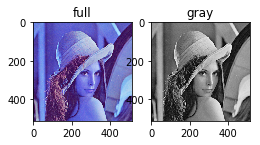

In [10]:
originImage = cv2.imread("lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)

(-0.5, 511.5, 511.5, -0.5)

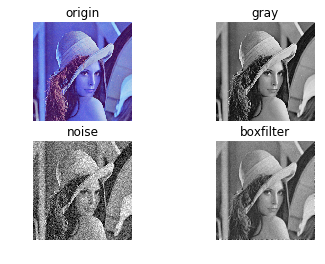

In [11]:
grayImage_noise = random_noise_generator(grayImage)
gray_image_boxfilter = normalized_box_filter(grayImage_noise,k_w=5, k_h=5)
plt.subplot(2, 2, 1)
plt.title("origin")
plt.imshow(originImage)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("gray")
plt.imshow(grayImage)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("noise")
plt.imshow(grayImage_noise)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("boxfilter")
plt.imshow(gray_image_boxfilter)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

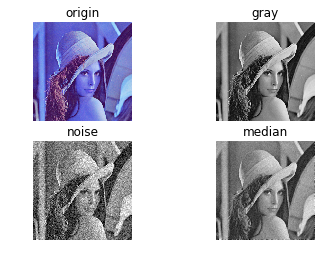

In [12]:
gray_image_medianfilter = median_filter(grayImage_noise,k_w=5, k_h=5)
plt.subplot(2, 2, 1)
plt.title("origin")
plt.imshow(originImage)
plt.axis('off')
plt.subplot(2, 2, 2)
plt.title("gray")
plt.imshow(grayImage)
plt.axis('off')
plt.subplot(2, 2, 3)
plt.title("noise")
plt.imshow(grayImage_noise)
plt.axis('off')
plt.subplot(2, 2, 4)
plt.title("median")
plt.imshow(gray_image_medianfilter)
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

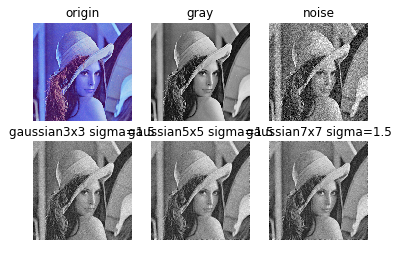

In [13]:
gray_image_gaussianfilter3x3 = Gaussian_filter(grayImage_noise,sigma=1.5, k_w = 3, k_h = 3)
gray_image_gaussianfilter5x5 = Gaussian_filter(grayImage_noise,sigma=1.5, k_w = 5, k_h = 5)
gray_image_gaussianfilter7x7 = Gaussian_filter(grayImage_noise,sigma=1.5, k_w = 7, k_h = 7)
plt.subplot(2, 3, 1)
plt.title("origin")
plt.imshow(originImage)
plt.axis('off')
plt.subplot(2, 3, 2)
plt.title("gray")
plt.imshow(grayImage)
plt.axis('off')
plt.subplot(2, 3, 3)
plt.title("noise")
plt.imshow(grayImage_noise)
plt.axis('off')
plt.subplot(2, 3, 4)
plt.title("gaussian3x3 sigma=1.5")
plt.imshow(gray_image_gaussianfilter3x3)
plt.axis('off')
plt.subplot(2, 3, 5)
plt.title("gaussian5x5 sigma=1.5")
plt.imshow(gray_image_gaussianfilter5x5)
plt.axis('off')
plt.subplot(2, 3, 6)
plt.title("gaussian7x7 sigma=1.5")
plt.imshow(gray_image_gaussianfilter7x7)
plt.axis('off')